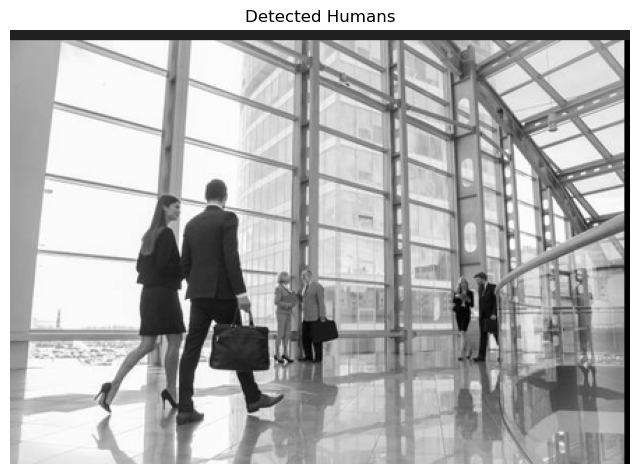

In [5]:
import cv2
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# Manual HoG computation function
def compute_hog_manual(image, cell_size=8, block_size=2, bins=9):
    # Step 1: Preprocess the image
    image = cv2.resize(image, (64, 128))  # Resize to fixed size
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale

    # Step 2: Compute gradients
    Gx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    Gy = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
    magnitude = np.sqrt(Gx**2 + Gy**2)
    orientation = np.rad2deg(np.arctan2(Gy, Gx)) % 180  # Angles in [0, 180)

    # Step 3: Divide the image into cells
    h, w = image.shape
    cell_rows = h // cell_size
    cell_cols = w // cell_size
    histograms = np.zeros((cell_rows, cell_cols, bins))

    # Step 4: Create histograms for each cell
    for i in range(cell_rows):
        for j in range(cell_cols):
            cell_mag = magnitude[i * cell_size:(i + 1) * cell_size, j * cell_size:(j + 1) * cell_size]
            cell_ori = orientation[i * cell_size:(i + 1) * cell_size, j * cell_size:(j + 1) * cell_size]
            
            # Bin the orientations
            hist, _ = np.histogram(
                cell_ori, bins=bins, range=(0, 180), weights=cell_mag
            )
            histograms[i, j, :] = hist

    # Step 5: Normalize using blocks
    block_stride = 1  # Overlap of 1 cell
    block_rows = cell_rows - block_size + 1
    block_cols = cell_cols - block_size + 1
    hog_features = []

    for i in range(block_rows):
        for j in range(block_cols):
            block = histograms[i:i + block_size, j:j + block_size, :].ravel()
            block_norm = block / (np.linalg.norm(block) + 1e-6)  # Avoid division by zero
            hog_features.extend(block_norm)

    return np.array(hog_features)

# Sliding window function
def sliding_window(image, step_size, window_size):
    for y in range(0, image.shape[0] - window_size[1], step_size):
        for x in range(0, image.shape[1] - window_size[0], step_size):
            yield (x, y, image[y:y + window_size[1], x:x + window_size[0]])

# Non-Maximum Suppression function
def non_max_suppression(boxes, overlapThresh=0.5):
    if len(boxes) == 0:
        return []
    
    boxes = np.array(boxes)
    x1, y1, x2, y2 = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    scores = boxes[:, 4]

    # Compute the area of the bounding boxes and sort by score
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(scores)[::-1]

    pick = []
    while len(idxs) > 0:
        i = idxs[0]
        pick.append(i)
        xx1 = np.maximum(x1[i], x1[idxs[1:]])
        yy1 = np.maximum(y1[i], y1[idxs[1:]])
        xx2 = np.minimum(x2[i], x2[idxs[1:]])
        yy2 = np.minimum(y2[i], y2[idxs[1:]])
        
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
        overlap = (w * h) / area[idxs[1:]]
        idxs = idxs[np.where(overlap <= overlapThresh)[0] + 1]
    
    return boxes[pick]

# Detection function
def detect_humans(image_path, reference_hog, step_size=8, window_size=(64, 128), threshold=0.8):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    boxes = []

    for (x, y, window) in sliding_window(image, step_size, window_size):
        if window.shape[:2] != window_size:
            continue
        
        # Compute HoG manually for the window
        window_hog = compute_hog_manual(window)
        
        # Calculate similarity with reference
        similarity = cosine_similarity([reference_hog], [window_hog])[0][0]
        
        if similarity > threshold:
            boxes.append((x, y, x + window_size[0], y + window_size[1], similarity))
    
    # Non-Maximum Suppression
    boxes = non_max_suppression(boxes)
    
    # Draw boxes on the image
    for (x1, y1, x2, y2, _) in boxes:
        cv2.rectangle(image, (x1, y1), (x2, y2), (255, 255, 255), 2)
    
    return image

# Main function
if __name__ == "__main__":
    # Load dataset
    human_image_path = "/home/student/Pictures/Screenshots/Screenshot from 2024-12-07 11-58-33.png"  # Replace with the path to a human image
    test_image_path = "/home/student/Pictures/Screenshots/Screenshot from 2024-12-07 12-09-05.png"   # Replace with the path to the test image

    # Compute reference HoG
    human_image = cv2.imread(human_image_path)
    reference_hog = compute_hog_manual(human_image)

    # Apply detection on the test image
    detected_image = detect_humans(test_image_path, reference_hog)

    # Plot results
    plt.figure(figsize=(8, 6))
    plt.imshow(detected_image, cmap='gray')
    plt.title("Detected Humans")
    plt.axis("off")
    plt.show()
